## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [3]:
from pathlib import Path
from functools import partial
from tqdm.auto import tqdm

import pandas as pd

import torch
from transformers import pipeline
from transformers.models.whisper import (WhisperTokenizer,
                                         WhisperTokenizerFast,
                                         WhisperFeatureExtractor,
                                         WhisperForConditionalGeneration)
from datasets import load_dataset
import evaluate

import matplotlib.pyplot as plt
import seaborn as sns

from dataloader.collator import DataCollatorSpeechSeq2SeqWithPadding
from dataloader.preprocessing_train.preprocessing import prepare_dataset_fct
from evaluation.eval_dataset_name_to_dataset_group import EVAL_DATASET_NAME_TO_DATASET_GROUP

device = torch.device('mps')
sns.set_theme(context="paper", style="ticks")

OUTPUT_DIR = Path("notebooks/outputs/evolution_of_prob_wrt_n_repetitions/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## Load model

In [4]:
pretrained_model_name_or_path = "openai/whisper-tiny"

model = WhisperForConditionalGeneration.from_pretrained(pretrained_model_name_or_path)
feature_extractor = WhisperFeatureExtractor.from_pretrained(pretrained_model_name_or_path)
tokenizer = WhisperTokenizerFast.from_pretrained(pretrained_model_name_or_path, language="english", task="transcribe")

model.generate = partial(model.generate, language="english", task="transcribe",
                         max_length=255, use_cache=True)

## Load dataset

In [5]:
dataset_name = "ami_validation"

ds = EVAL_DATASET_NAME_TO_DATASET_GROUP[dataset_name]()[dataset_name]

if dataset_name != "librispeech_dummy":
    ds = ds.select([6616, 11005])

Found cached dataset ami (/Users/Tony/.cache/huggingface/datasets/edinburghcstr___ami/ihm/0.0.0/0d128d0aa8145d0f16f3d5b4da86c5d5759dbe9e8f947fda04b25edb56442bd5)


In [6]:
prepare_dataset = partial(prepare_dataset_fct, tokenizer=tokenizer, feature_extractor=feature_extractor)
ds = ds.map(prepare_dataset, num_proc=4).with_format("pt")

num_proc must be <= 2. Reducing num_proc to 2 for dataset of size 2.
Loading cached processed dataset at /Users/Tony/.cache/huggingface/datasets/edinburghcstr___ami/ihm/0.0.0/0d128d0aa8145d0f16f3d5b4da86c5d5759dbe9e8f947fda04b25edb56442bd5/cache-2cee9493e59c71b7_*_of_00002.arrow


## Predict

### Example 1

In [7]:
x = ds[0]

x["text"]

'YEAH'

In [8]:
outputs = model.generate(x["input_features"][None, ...], output_scores=True, return_dict_in_generate=True)

In [9]:
tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True)

[' Ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha']

In [10]:
scores = torch.cat(outputs.scores)
scores = torch.nn.functional.softmax(scores, dim=-1)

scores.shape

torch.Size([254, 51865])

In [11]:
decoded_tokens = [f"{idx}: {tokenizer.decode(token)}" for idx, token in enumerate(outputs.sequences[0, 1:])]
prob_tokens = scores.take_along_dim(outputs.sequences.reshape(-1, 1)[1:, :], dim=-1).flatten().numpy()

Figure saved at `notebooks/outputs/evolution_of_prob_wrt_n_repetitions/example_1.png`.


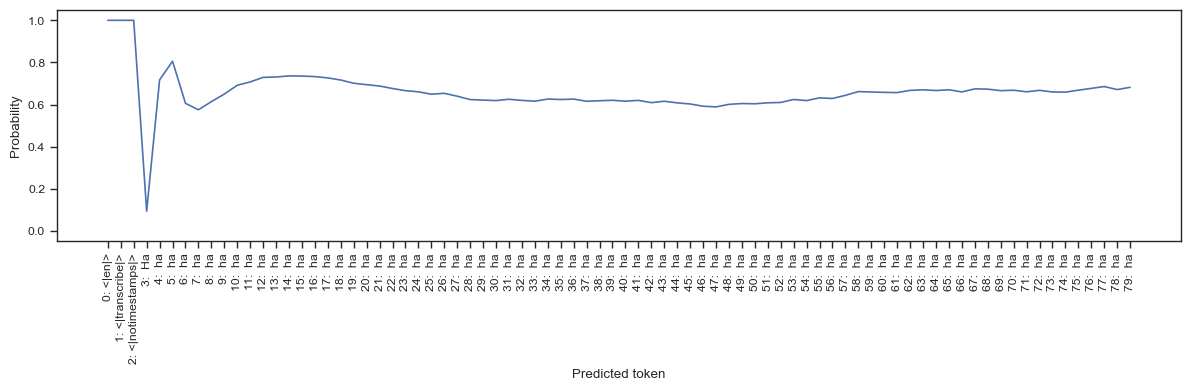

In [12]:
n_samples = 80

plt.figure(figsize=(12, 4))
sns.lineplot(x=decoded_tokens[:n_samples], y=prob_tokens[:n_samples])
# plt.axhline(y=0.5, color="r", ls="--", label=r'$y = 0.5$')
# plt.legend()
plt.ylim(-0.05, 1.05)
plt.xticks(rotation=90)
plt.xlabel("Predicted token")
plt.ylabel("Probability")
plt.tight_layout()

savepath = OUTPUT_DIR / "example_1.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")

### Example 2

In [13]:
"SO WE HAVE OH NO WHAT'S THAT".lower()

"so we have oh no what's that"

In [14]:
x = ds[1]

x["text"]

"SO WE HAVE OH NO WHAT'S THAT"

In [15]:
outputs = model.generate(x["input_features"][None, ...], output_scores=True, return_dict_in_generate=True)

In [16]:
tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True)

[' So we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we have, we']

In [17]:
scores = torch.cat(outputs.scores)
scores = torch.nn.functional.softmax(scores, dim=-1)

scores.shape

torch.Size([254, 51865])

In [18]:
decoded_tokens = [f"{idx}: {tokenizer.decode(token)}" for idx, token in enumerate(outputs.sequences[0, 1:])]
prob_tokens = scores.take_along_dim(outputs.sequences.reshape(-1, 1)[1:, :], dim=-1).flatten().numpy()

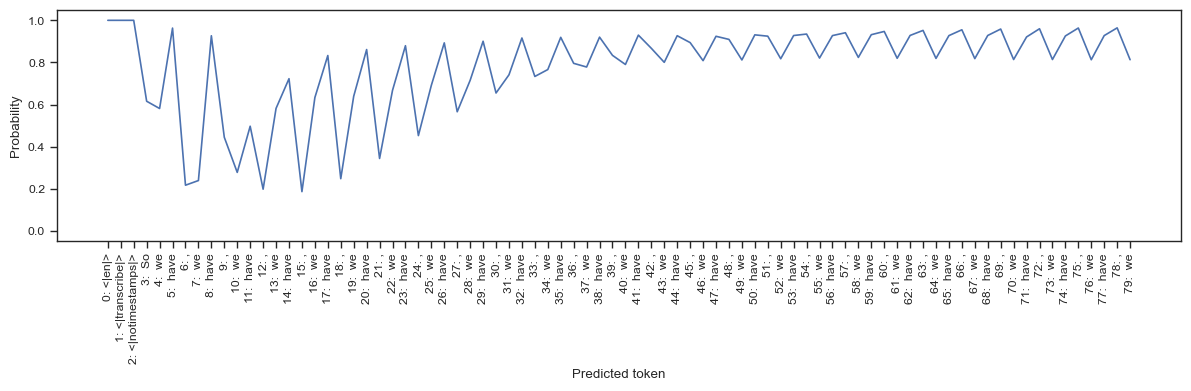

In [19]:
n_samples = 80

plt.figure(figsize=(12, 4))
sns.lineplot(x=decoded_tokens[:n_samples], y=prob_tokens[:n_samples])
# plt.axhline(y=0.5, color="r", ls="--", label=r'$y = 0.5$')
# plt.legend()
plt.ylim(-0.05, 1.05)
plt.xticks(rotation=90)
plt.xlabel("Predicted token")
plt.ylabel("Probability")
plt.tight_layout();

Figure saved at `notebooks/outputs/evolution_of_prob_wrt_n_repetitions/example_2.png`.


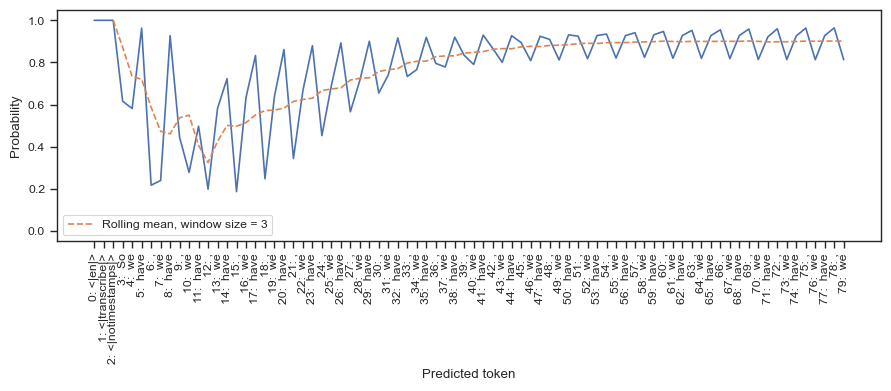

In [33]:
df = pd.DataFrame({"Predicted token": decoded_tokens[:n_samples], "Probability": prob_tokens[:n_samples]})

window = 3
df["Rolling mean"] = df["Probability"].rolling(window).mean()

n_samples = 80

plt.figure(figsize=(9, 4))
sns.lineplot(data=df, x="Predicted token", y="Probability")
sns.lineplot(data=df, x="Predicted token", y="Rolling mean", ls="--", label=f"Rolling mean, window size = {window}")
# plt.axhline(y=0.5, color="r", ls="--", label=r'$y = 0.5$')
plt.legend()
plt.ylim(-0.05, 1.05)
plt.xticks(rotation=90)
# plt.xlabel("Predicted token")
# plt.ylabel("Probability")
plt.tight_layout()

savepath = OUTPUT_DIR / "example_2.png"
savepath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(savepath)
print(f"Figure saved at `{savepath}`.")